In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_score, recall_score, f1_score)
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('All libraries loaded successfully!')
print('Ready to hunt some bots.')

All libraries loaded successfully!
Ready to hunt some bots.


In [2]:
df = pd.read_csv('reddit_dead_internet_analysis_2026.csv')
print(f'Dataset Shape: {df.shape[0]} comments, {df.shape[1]} features')
print('\n' + '='*50)
print('COLUMNS:')
print('='*50)
for col in df.columns:
    print(f'  - {col}')

Dataset Shape: 500 comments, 11 features

COLUMNS:
  - comment_id
  - subreddit
  - account_age_days
  - user_karma
  - reply_delay_seconds
  - sentiment_score
  - avg_word_length
  - contains_links
  - is_bot_flag
  - bot_type_label
  - bot_probability


In [3]:
print('FIRST 5 ROWS:')
print('='*80)
df.head()

FIRST 5 ROWS:


,comment_id,subreddit,account_age_days,user_karma,reply_delay_seconds,sentiment_score,avg_word_length,contains_links,is_bot_flag,bot_type_label,bot_probability
0,t1_3148938807,funny,2264,34192,1854,-0.60,4.62,False,False,None (Human),0.093
1,t1_2516748923,gaming,1654,2812,1033,0.15,5.84,False,False,None (Human),0.117
2,t1_833922318,politics,2442,37109,2703,0.35,5.73,False,False,None (Human),0.115
3,t1_3987809057,funny,168,32997,2811,-0.74,4.58,False,False,None (Human),0.094
4,t1_3931039688,gaming,801,25088,1721,-0.96,5.78,False,False,None (Human),0.116


In [4]:
print('DATA INFO:')
print('='*50)
df.info()

DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   comment_id           500 non-null    object 
 1   subreddit            500 non-null    object 
 2   account_age_days     500 non-null    int64  
 3   user_karma           500 non-null    int64  
 4   reply_delay_seconds  500 non-null    int64  
 5   sentiment_score      500 non-null    float64
 6   avg_word_length      500 non-null    float64
 7   contains_links       500 non-null    bool   
 8   is_bot_flag          500 non-null    bool   
 9   bot_type_label       500 non-null    object 
 10  bot_probability      500 non-null    float64
dtypes: bool(2), float64(3), int64(3), object(3)
memory usage: 36.3+ KB


TARGET DISTRIBUTION:
Humans (False): 282 (56.4%)
Bots (True):    218 (43.6%)


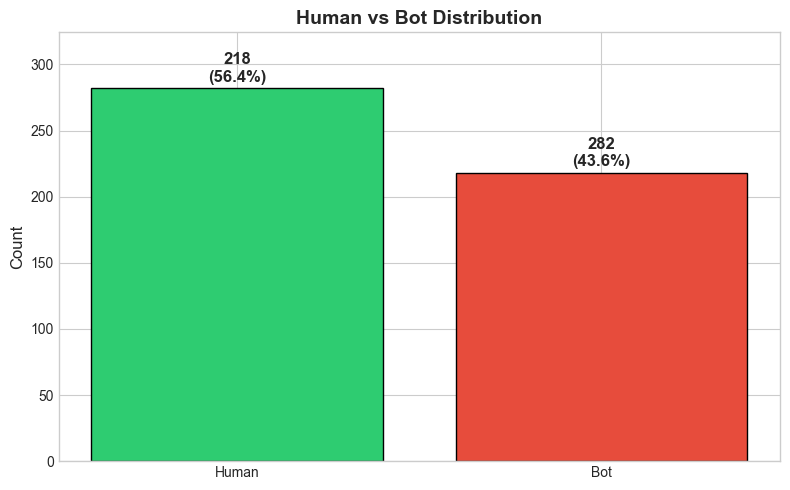

<Figure size 640x480 with 0 Axes>

In [5]:
print('TARGET DISTRIBUTION:')
print('='*50)
target_counts = df['is_bot_flag'].value_counts()
target_pct = df['is_bot_flag'].value_counts(normalize=True) * 100

print(f'Humans (False): {target_counts[False]} ({target_pct[False]:.1f}%)')
print(f'Bots (True):    {target_counts[True]} ({target_pct[True]:.1f}%)')

fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#2ecc71', '#e74c3c']  # Green for humans, red for bots
bars = ax.bar(['Human', 'Bot'], [target_counts[False], target_counts[True]], color=colors, edgecolor='black')

for bar, count, pct in zip(bars, target_counts.values[::-1], [target_pct[False], target_pct[True]]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{count}\n({pct:.1f}%)', ha='center', fontsize=12, fontweight='bold')

ax.set_ylabel('Count', fontsize=12)
ax.set_title('Human vs Bot Distribution', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(target_counts.values) * 1.15)
plt.tight_layout()
plt.show()
plt.savefig('human_bot_distribution.png')

BOT TYPE BREAKDOWN:
bot_type_label
None (Human)         282
Engagement Farmer     86
AI Summarizer         66
Reprint Bot           66
Name: count, dtype: int64


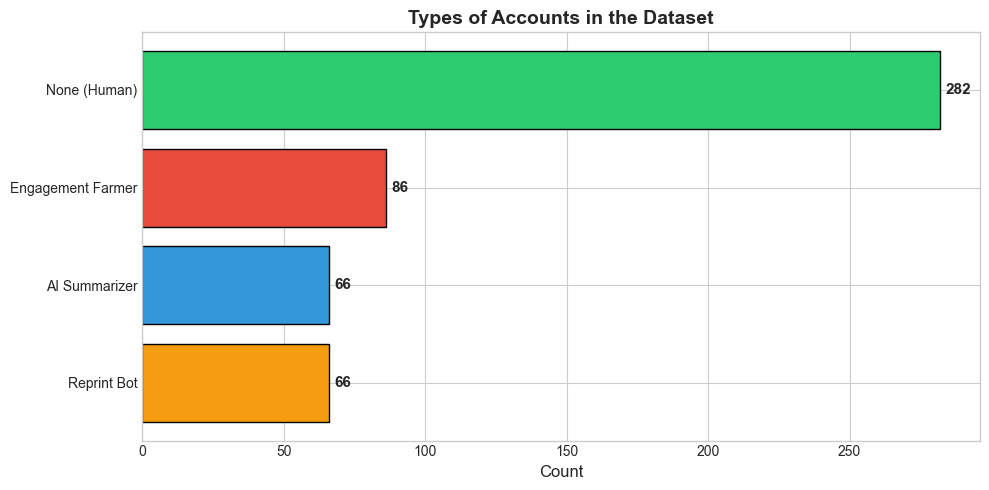

<Figure size 640x480 with 0 Axes>

In [6]:
print('BOT TYPE BREAKDOWN:')
print('='*50)
bot_types = df['bot_type_label'].value_counts()
print(bot_types)

fig, ax = plt.subplots(figsize=(10, 5))
bot_colors = {'None (Human)': '#2ecc71', 'Engagement Farmer': '#e74c3c',
              'AI Summarizer': '#3498db', 'Reprint Bot': '#f39c12'}
colors = [bot_colors.get(x, '#95a5a6') for x in bot_types.index]
bars = ax.barh(bot_types.index, bot_types.values, color=colors, edgecolor='black')

for bar, count in zip(bars, bot_types.values):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
            str(count), va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Count', fontsize=12)
ax.set_title('Types of Accounts in the Dataset', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()
plt.savefig('bot_type_breakdown.png')

In [7]:
print('MISSING VALUES:')
print('='*50)
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100

if missing.sum() == 0:
    print('Zero missing values. This data is cleaner than my apartment.')
    print('(Low bar, but still.)')
else:
    for col in df.columns:
        if missing[col] > 0:
            print(f'{col}: {missing[col]} ({missing_pct[col]:.1f}%)')

MISSING VALUES:
Zero missing values. This data is cleaner than my apartment.
(Low bar, but still.)


In [8]:
print('DUPLICATE ROWS:')
print('='*50)
duplicates = df.duplicated().sum()
print(f'Duplicate rows found: {duplicates}')

if duplicates == 0:
    print('No duplicates. Each comment is unique.')

DUPLICATE ROWS:
Duplicate rows found: 0
No duplicates. Each comment is unique.


In [9]:
print('NUMERICAL FEATURES - STATISTICAL SUMMARY:')
print('='*70)

numerical_cols = ['account_age_days', 'user_karma', 'reply_delay_seconds',
                  'sentiment_score', 'avg_word_length', 'bot_probability']

df[numerical_cols].describe().round(2)

NUMERICAL FEATURES - STATISTICAL SUMMARY:


,account_age_days,user_karma,reply_delay_seconds,sentiment_score,avg_word_length,bot_probability
count,500.00,500.00,500.00,500.00,500.00,500.00
mean,1157.62,25248.20,1030.70,0.01,5.65,0.16
std,951.77,14122.97,1184.41,0.58,0.90,0.07
min,1.00,308.00,1.00,-1.00,4.03,0.08
25%,163.00,13427.25,7.00,-0.47,4.97,0.10
50%,1092.50,24778.50,459.00,0.02,5.70,0.12
75%,1960.00,37111.50,1925.00,0.50,6.25,0.20
max,2996.00,49734.00,3577.00,1.00,7.49,0.46


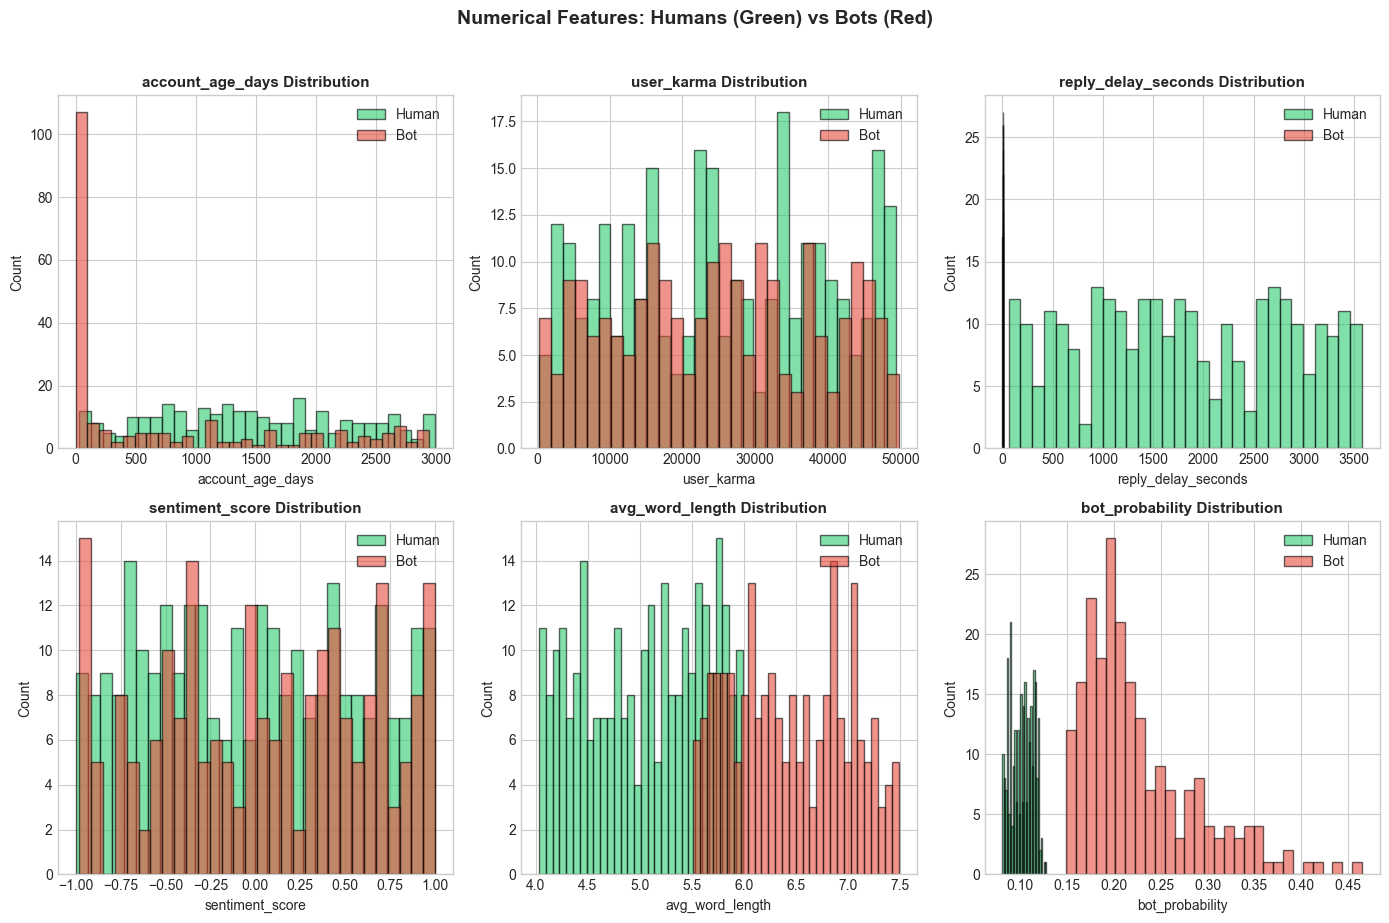

<Figure size 640x480 with 0 Axes>

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    ax = axes[idx]
    humans = df[df['is_bot_flag'] == False][col]
    bots = df[df['is_bot_flag'] == True][col]

    ax.hist(humans, bins=30, alpha=0.6, label='Human', color='#2ecc71', edgecolor='black')
    ax.hist(bots, bins=30, alpha=0.6, label='Bot', color='#e74c3c', edgecolor='black')

    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title(f'{col} Distribution', fontsize=11, fontweight='bold')
    ax.legend()

plt.suptitle('Numerical Features: Humans (Green) vs Bots (Red)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
plt.savefig('numerical_feature_distributions.png')

In [11]:
print('CATEGORICAL FEATURES:')
print('='*50)

print('\nSubreddit Distribution:')
print(df['subreddit'].value_counts())

print('\nContains Links:')
print(df['contains_links'].value_counts())

CATEGORICAL FEATURES:

Subreddit Distribution:
subreddit
funny         94
gaming        92
politics      83
pics          81
worldnews     78
technology    72
Name: count, dtype: int64

Contains Links:
contains_links
False    386
True     114
Name: count, dtype: int64


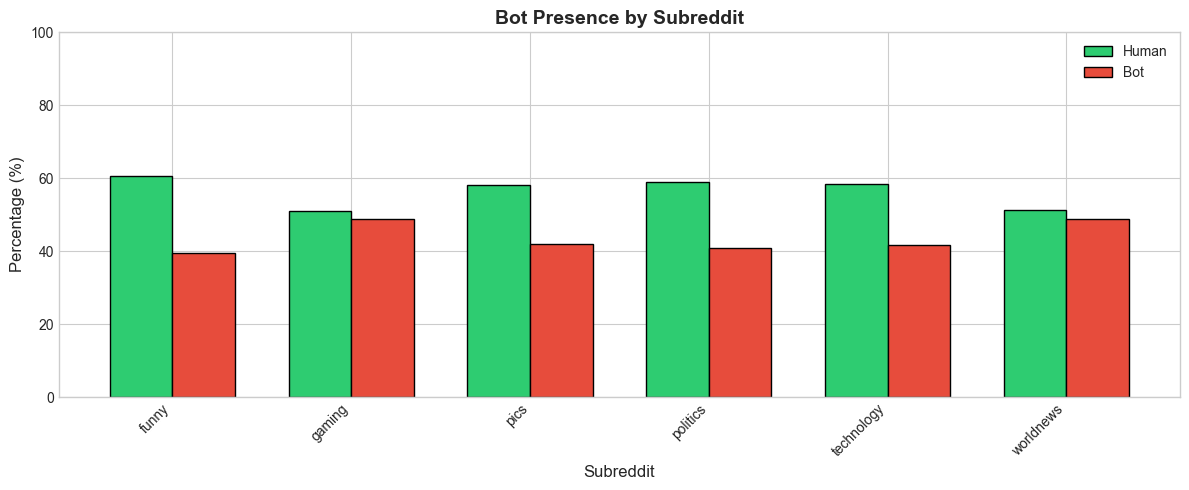


Bot Percentage by Subreddit:
subreddit
gaming        48.9
worldnews     48.7
pics          42.0
technology    41.7
politics      41.0
funny         39.4
Name: True, dtype: float64


<Figure size 640x480 with 0 Axes>

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))

subreddit_bot = pd.crosstab(df['subreddit'], df['is_bot_flag'], normalize='index') * 100

x = np.arange(len(subreddit_bot.index))
width = 0.35

bars1 = ax.bar(x - width/2, subreddit_bot[False], width, label='Human', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x + width/2, subreddit_bot[True], width, label='Bot', color='#e74c3c', edgecolor='black')

ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xlabel('Subreddit', fontsize=12)
ax.set_title('Bot Presence by Subreddit', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(subreddit_bot.index, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()
plt.savefig('bot_presence_by_subreddit.png')

print('\nBot Percentage by Subreddit:')
print(subreddit_bot[True].sort_values(ascending=False).round(1))

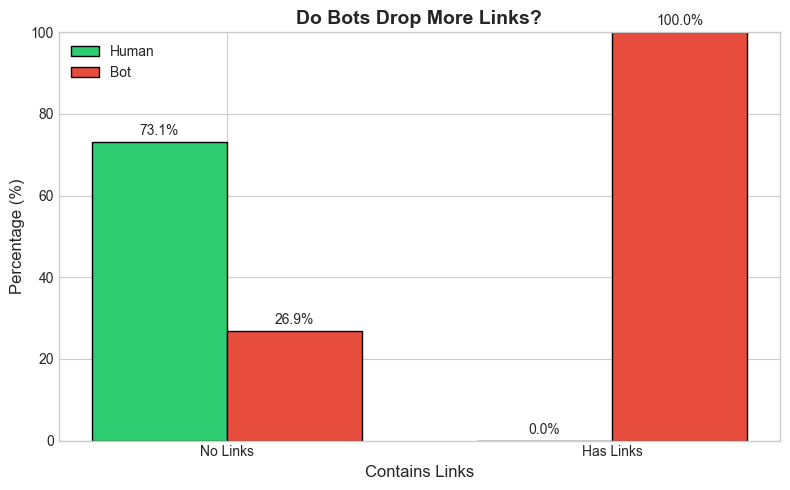

<Figure size 640x480 with 0 Axes>

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

link_bot = pd.crosstab(df['contains_links'], df['is_bot_flag'], normalize='index') * 100

x = np.arange(len(link_bot.index))
width = 0.35

bars1 = ax.bar(x - width/2, link_bot[False], width, label='Human', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x + width/2, link_bot[True], width, label='Bot', color='#e74c3c', edgecolor='black')

ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xlabel('Contains Links', fontsize=12)
ax.set_title('Do Bots Drop More Links?', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['No Links', 'Has Links'])
ax.legend()
ax.set_ylim(0, 100)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
plt.savefig('bot_link_distribution.png')

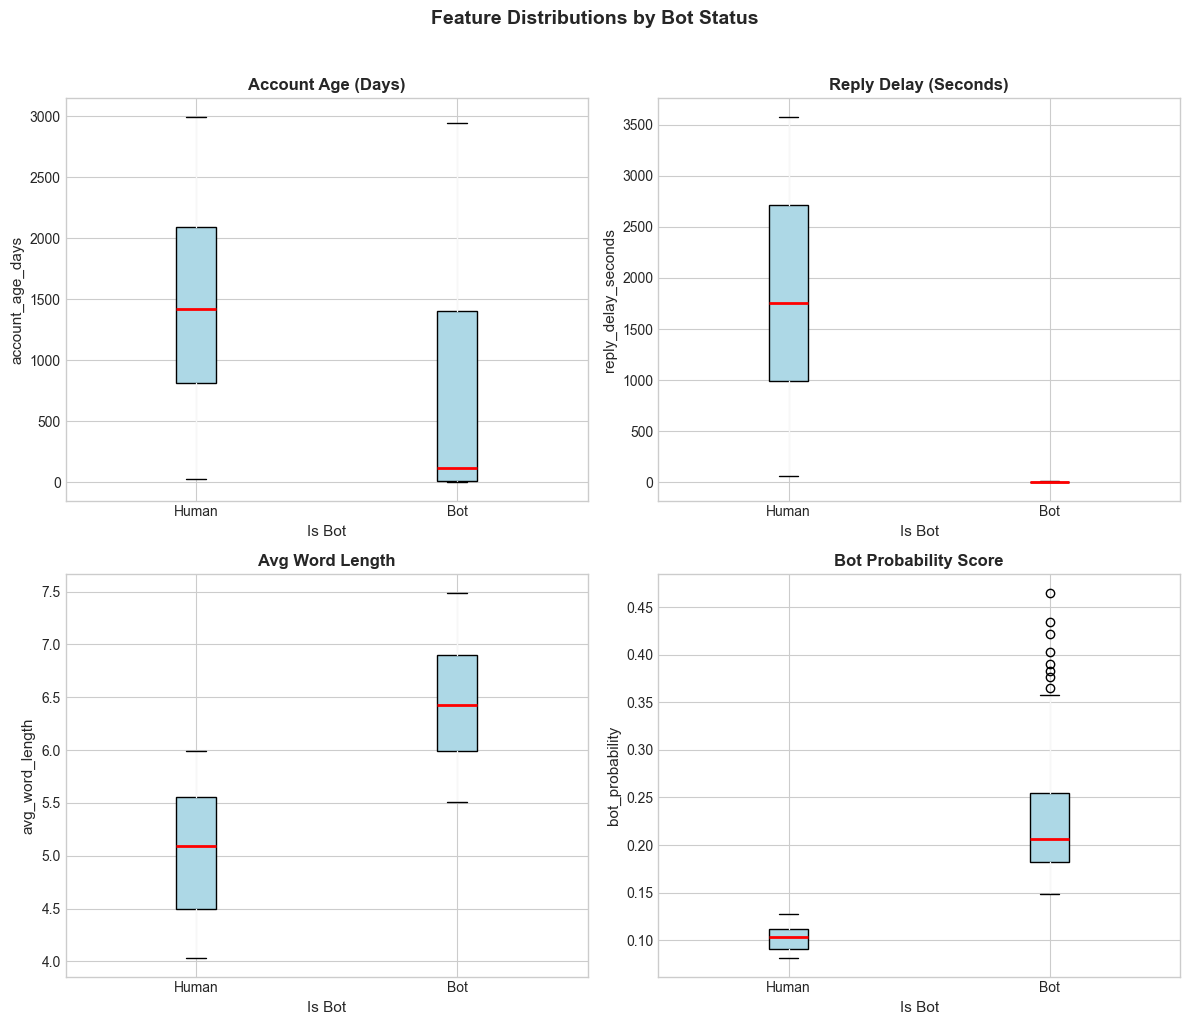

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

key_features = ['account_age_days', 'reply_delay_seconds', 'avg_word_length', 'bot_probability']
titles = ['Account Age (Days)', 'Reply Delay (Seconds)', 'Avg Word Length', 'Bot Probability Score']

for ax, feature, title in zip(axes.flatten(), key_features, titles):
    df.boxplot(column=feature, by='is_bot_flag', ax=ax,
               patch_artist=True,
               boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color='red', linewidth=2))
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Is Bot', fontsize=11)
    ax.set_xticklabels(['Human', 'Bot'])
    ax.set_ylabel(feature, fontsize=11)

plt.suptitle('Feature Distributions by Bot Status', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

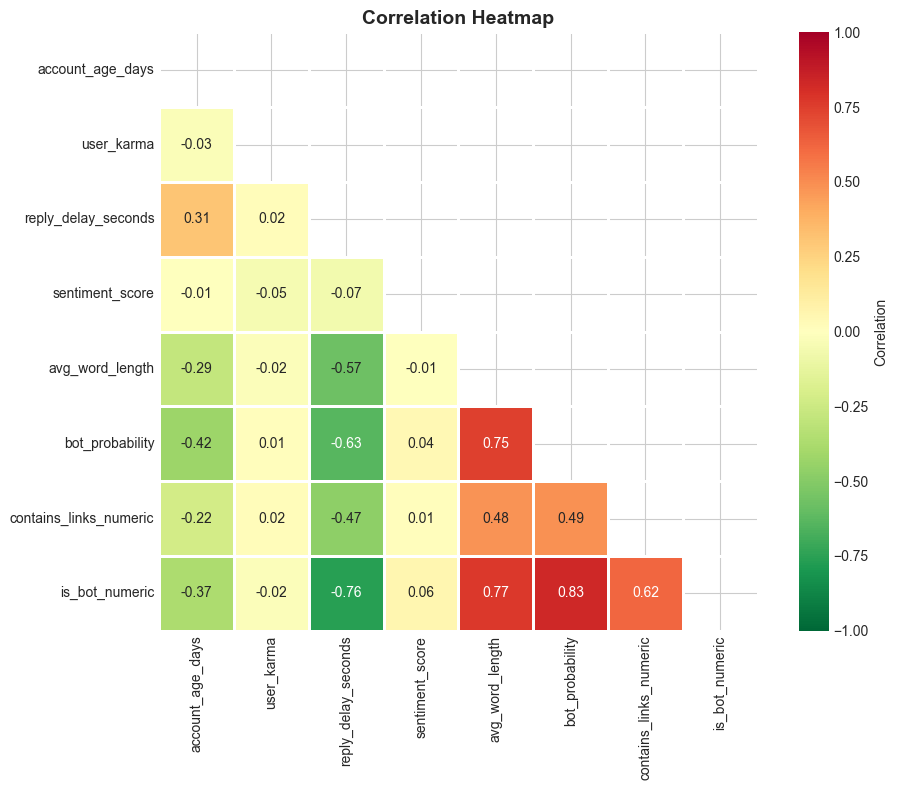

<Figure size 640x480 with 0 Axes>

In [15]:
df_corr = df.copy()
df_corr['is_bot_numeric'] = df_corr['is_bot_flag'].astype(int)
df_corr['contains_links_numeric'] = df_corr['contains_links'].astype(int)

corr_cols = ['account_age_days', 'user_karma', 'reply_delay_seconds', 'sentiment_score',
             'avg_word_length', 'bot_probability', 'contains_links_numeric', 'is_bot_numeric']

corr_matrix = df_corr[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn_r', center=0,
            square=True, linewidths=1, ax=ax, vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.savefig('correlation_heatmap.png')

In [16]:
print('STATISTICAL SIGNIFICANCE TESTS')
print('='*70)
print('Testing if features significantly differ between humans and bots')
print('Using Mann-Whitney U test (non-parametric, handles non-normal data)')
print('='*70)

numerical_features = ['account_age_days', 'user_karma', 'reply_delay_seconds',
                      'sentiment_score', 'avg_word_length', 'bot_probability']

stat_results = []

for feature in numerical_features:
    humans = df[df['is_bot_flag'] == False][feature]
    bots = df[df['is_bot_flag'] == True][feature]

    stat, pvalue = mannwhitneyu(humans, bots, alternative='two-sided')

    pooled_std = np.sqrt(((len(humans)-1)*humans.std()**2 + (len(bots)-1)*bots.std()**2) /
                         (len(humans) + len(bots) - 2))
    cohens_d = abs(humans.mean() - bots.mean()) / pooled_std if pooled_std > 0 else 0

    if cohens_d < 0.2:
        effect_interp = 'Negligible'
    elif cohens_d < 0.5:
        effect_interp = 'Small'
    elif cohens_d < 0.8:
        effect_interp = 'Medium'
    else:
        effect_interp = 'Large'

    significant = 'Yes' if pvalue < 0.05 else 'No'

    stat_results.append({
        'Feature': feature,
        'Human Mean': humans.mean(),
        'Bot Mean': bots.mean(),
        'P-Value': pvalue,
        'Significant': significant,
        "Cohen's d": cohens_d,
        'Effect Size': effect_interp
    })

stat_df = pd.DataFrame(stat_results)
stat_df['P-Value'] = stat_df['P-Value'].apply(lambda x: f'{x:.2e}' if x < 0.001 else f'{x:.4f}')
stat_df["Cohen's d"] = stat_df["Cohen's d"].round(3)
stat_df['Human Mean'] = stat_df['Human Mean'].round(2)
stat_df['Bot Mean'] = stat_df['Bot Mean'].round(2)

print('\nRESULTS:')
print(stat_df.to_string(index=False))

STATISTICAL SIGNIFICANCE TESTS
Testing if features significantly differ between humans and bots
Using Mann-Whitney U test (non-parametric, handles non-normal data)

RESULTS:
            Feature  Human Mean  Bot Mean  P-Value Significant  Cohen's d Effect Size
   account_age_days     1465.63    759.19 5.37e-21         Yes      0.798      Medium
         user_karma    25514.40  24903.84   0.6235          No      0.043  Negligible
reply_delay_seconds     1823.03      5.76 4.09e-82         Yes      2.365       Large
    sentiment_score       -0.01      0.05   0.1969          No      0.115  Negligible
    avg_word_length        5.05      6.44 8.43e-71         Yes      2.431       Large
    bot_probability        0.10      0.23 4.70e-82         Yes      3.009       Large


In [17]:
print('CHI-SQUARE TESTS FOR CATEGORICAL FEATURES')
print('='*70)
print('Testing if categorical features are associated with bot status')
print('='*70)

categorical_features = ['subreddit', 'contains_links']
chi_results = []

for feature in categorical_features:
    
    contingency = pd.crosstab(df[feature], df['is_bot_flag'])

    chi2, pvalue, dof, expected = chi2_contingency(contingency)

    n = contingency.sum().sum()
    min_dim = min(contingency.shape[0] - 1, contingency.shape[1] - 1)
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

    if cramers_v < 0.1:
        effect_interp = 'Negligible'
    elif cramers_v < 0.3:
        effect_interp = 'Small'
    elif cramers_v < 0.5:
        effect_interp = 'Medium'
    else:
        effect_interp = 'Large'

    significant = 'Yes' if pvalue < 0.05 else 'No'

    chi_results.append({
        'Feature': feature,
        'Chi-Square': round(chi2, 2),
        'P-Value': pvalue,
        'Significant': significant,
        "Cramer's V": round(cramers_v, 3),
        'Effect Size': effect_interp
    })

chi_df = pd.DataFrame(chi_results)
chi_df['P-Value'] = chi_df['P-Value'].apply(lambda x: f'{x:.2e}' if x < 0.001 else f'{x:.4f}')

print('\nRESULTS:')
print(chi_df.to_string(index=False))

CHI-SQUARE TESTS FOR CATEGORICAL FEATURES
Testing if categorical features are associated with bot status

RESULTS:
       Feature  Chi-Square  P-Value Significant  Cramer's V Effect Size
     subreddit        3.00   0.6993          No       0.078  Negligible
contains_links      188.06 8.42e-43         Yes       0.613       Large


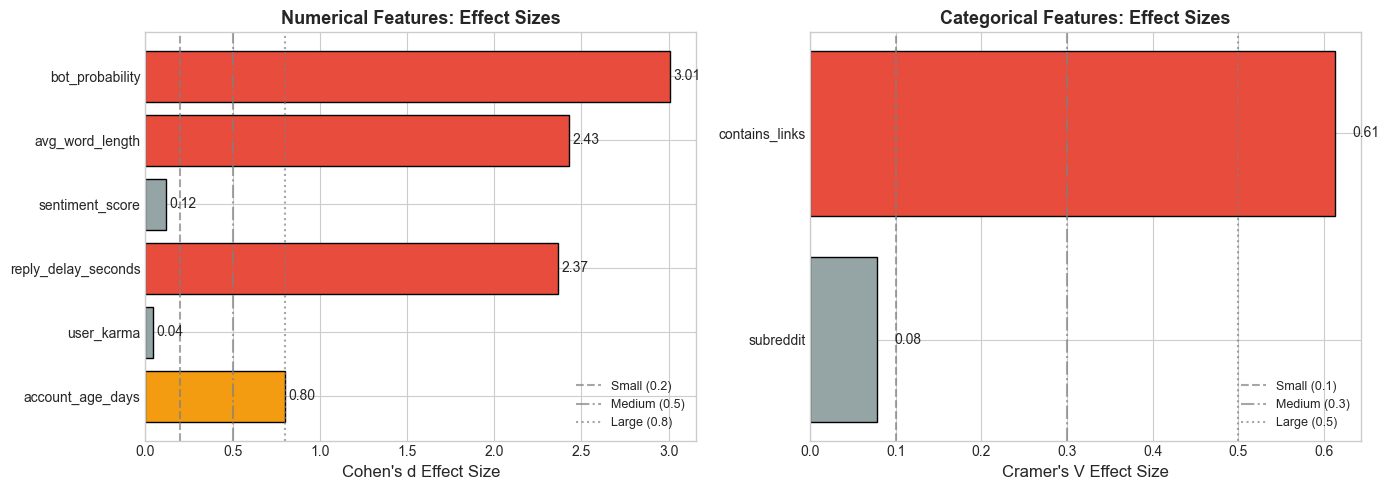

<Figure size 640x480 with 0 Axes>

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
num_results = pd.DataFrame(stat_results)
colors = ['#e74c3c' if x >= 0.8 else '#f39c12' if x >= 0.5 else '#3498db' if x >= 0.2 else '#95a5a6'
          for x in num_results["Cohen's d"]]
bars = ax1.barh(num_results['Feature'], num_results["Cohen's d"], color=colors, edgecolor='black')
ax1.axvline(x=0.2, color='gray', linestyle='--', alpha=0.7, label='Small (0.2)')
ax1.axvline(x=0.5, color='gray', linestyle='-.', alpha=0.7, label='Medium (0.5)')
ax1.axvline(x=0.8, color='gray', linestyle=':', alpha=0.7, label='Large (0.8)')
ax1.set_xlabel("Cohen's d Effect Size", fontsize=12)
ax1.set_title('Numerical Features: Effect Sizes', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)

for bar, val in zip(bars, num_results["Cohen's d"]):
    ax1.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f'{val:.2f}', va='center', fontsize=10)

ax2 = axes[1]
cat_results = pd.DataFrame(chi_results)
colors = ['#e74c3c' if x >= 0.5 else '#f39c12' if x >= 0.3 else '#3498db' if x >= 0.1 else '#95a5a6'
          for x in cat_results["Cramer's V"]]
bars = ax2.barh(cat_results['Feature'], cat_results["Cramer's V"], color=colors, edgecolor='black')
ax2.axvline(x=0.1, color='gray', linestyle='--', alpha=0.7, label='Small (0.1)')
ax2.axvline(x=0.3, color='gray', linestyle='-.', alpha=0.7, label='Medium (0.3)')
ax2.axvline(x=0.5, color='gray', linestyle=':', alpha=0.7, label='Large (0.5)')
ax2.set_xlabel("Cramer's V Effect Size", fontsize=12)
ax2.set_title('Categorical Features: Effect Sizes', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)

for bar, val in zip(bars, cat_results["Cramer's V"]):
    ax2.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f'{val:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()
plt.savefig('feature_effect_sizes.png')

In [19]:
print('='*70)
print('FEATURE IMPORTANCE SUMMARY (Based on Statistical Tests)')
print('='*70)

all_features = []

for r in stat_results:
    all_features.append({
        'Feature': r['Feature'],
        'Test': 'Mann-Whitney U',
        'P-Value': r['P-Value'],
        'Effect Size': r["Cohen's d"],
        'Interpretation': r['Effect Size'],
        'Significant': r['Significant']
    })

for r in chi_results:
    all_features.append({
        'Feature': r['Feature'],
        'Test': 'Chi-Square',
        'P-Value': r['P-Value'],
        'Effect Size': r["Cramer's V"],
        'Interpretation': r['Effect Size'],
        'Significant': r['Significant']
    })

summary_df = pd.DataFrame(all_features)
summary_df = summary_df.sort_values('Effect Size', ascending=False)

print(summary_df.to_string(index=False))

print('\n' + '='*70)
sig_count = summary_df[summary_df['Significant'] == 'Yes'].shape[0]
total_count = summary_df.shape[0]
print(f'VERDICT: {sig_count} out of {total_count} features show significant differences between humans and bots.')

FEATURE IMPORTANCE SUMMARY (Based on Statistical Tests)
            Feature           Test      P-Value  Effect Size Interpretation Significant
    bot_probability Mann-Whitney U 4.701660e-82     3.008617          Large         Yes
    avg_word_length Mann-Whitney U 8.432791e-71     2.431378          Large         Yes
reply_delay_seconds Mann-Whitney U 4.093540e-82     2.365284          Large         Yes
   account_age_days Mann-Whitney U 5.368819e-21     0.797604         Medium         Yes
     contains_links     Chi-Square 8.424517e-43     0.613000          Large         Yes
    sentiment_score Mann-Whitney U 1.968588e-01     0.115178     Negligible          No
          subreddit     Chi-Square 6.992813e-01     0.078000     Negligible          No
         user_karma Mann-Whitney U 6.234774e-01     0.043198     Negligible          No

VERDICT: 5 out of 8 features show significant differences between humans and bots.


In [20]:
print('DATA PREPROCESSING')
print('='*50)

df_model = df.copy()

le_subreddit = LabelEncoder()
df_model['subreddit_encoded'] = le_subreddit.fit_transform(df_model['subreddit'])

df_model['contains_links'] = df_model['contains_links'].astype(int)
df_model['is_bot_flag'] = df_model['is_bot_flag'].astype(int)

feature_cols = ['subreddit_encoded', 'account_age_days', 'user_karma', 'reply_delay_seconds',
                'sentiment_score', 'avg_word_length', 'contains_links']

X = df_model[feature_cols]
y = df_model['is_bot_flag']

print(f'Features used: {len(feature_cols)}')
for col in feature_cols:
    print(f'  - {col}')
print(f'\nTarget: is_bot_flag')
print(f'Total samples: {len(X)}')

DATA PREPROCESSING
Features used: 7
  - subreddit_encoded
  - account_age_days
  - user_karma
  - reply_delay_seconds
  - sentiment_score
  - avg_word_length
  - contains_links

Target: is_bot_flag
Total samples: 500


In [21]:
print('SPLITTING DATA')
print('='*50)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.0f}%)')
print(f'Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.0f}%)')
print(f'\nTarget distribution in training set:')
print(f'  Humans: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)')
print(f'  Bots: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)')

SPLITTING DATA
Training set: 400 samples (80%)
Test set: 100 samples (20%)

Target distribution in training set:
  Humans: 226 (56.5%)
  Bots: 174 (43.5%)


In [22]:
print('SCALING FEATURES')
print('='*50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('StandardScaler applied.')
print('This normalizes features to mean=0, std=1.')
print('Essential for distance-based models like KNN and SVM.')

SCALING FEATURES
StandardScaler applied.
This normalizes features to mean=0, std=1.
Essential for distance-based models like KNN and SVM.


In [23]:
print('THE CONTENDERS')
print('='*50)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'Naive Bayes': GaussianNB()
}

for name in models:
    print(f'  - {name}')

print('\n7 models. 1 champion. Let the battle begin.')

THE CONTENDERS
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - Gradient Boosting
  - K-Nearest Neighbors
  - SVM (RBF)
  - Naive Bayes

7 models. 1 champion. Let the battle begin.


In [24]:
print('TRAINING AND EVALUATING...')
print('='*70)

results = []
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f'\nTraining {name}...')

    if name in ['K-Nearest Neighbors', 'SVM (RBF)']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv_folds, scoring='accuracy')
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy')

    test_acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results.append({
        'Model': name,
        'Test Accuracy': test_acc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'cv_scores': cv_scores,
        'model': model,
        'y_proba': y_proba
    })

    print(f'  Test Accuracy: {test_acc:.4f}')
    print(f'  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})')

print('\n' + '='*70)
print('Training complete!')

TRAINING AND EVALUATING...

Training Logistic Regression...
  Test Accuracy: 1.0000
  CV Score: 0.9975 (+/- 0.0050)

Training Decision Tree...
  Test Accuracy: 1.0000
  CV Score: 0.9975 (+/- 0.0050)

Training Random Forest...
  Test Accuracy: 1.0000
  CV Score: 0.9975 (+/- 0.0050)

Training Gradient Boosting...
  Test Accuracy: 1.0000
  CV Score: 0.9975 (+/- 0.0050)

Training K-Nearest Neighbors...
  Test Accuracy: 0.9800
  CV Score: 0.9675 (+/- 0.0269)

Training SVM (RBF)...
  Test Accuracy: 0.9800
  CV Score: 0.9850 (+/- 0.0122)

Training Naive Bayes...
  Test Accuracy: 1.0000
  CV Score: 1.0000 (+/- 0.0000)

Training complete!


In [25]:
print('\n' + '='*70)
print('                    MODEL LEADERBOARD')
print('='*70)

results_df = pd.DataFrame([{k: v for k, v in r.items() if k not in ['cv_scores', 'model', 'y_proba']}
                           for r in results])

results_df = results_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

rankings = ['[CHAMPION]', '[#2]', '[#3]', '[#4]', '[#5]', '[#6]', '[#7]']

for idx, row in results_df.iterrows():
    rank = rankings[idx]
    print(f"{rank:12} {row['Model']:25} | Accuracy: {row['Test Accuracy']*100:.2f}% | ROC-AUC: {row['ROC-AUC']:.3f}")

print('='*70)


                    MODEL LEADERBOARD
[CHAMPION]   Logistic Regression       | Accuracy: 100.00% | ROC-AUC: 1.000
[#2]         Decision Tree             | Accuracy: 100.00% | ROC-AUC: 1.000
[#3]         Random Forest             | Accuracy: 100.00% | ROC-AUC: 1.000
[#4]         Gradient Boosting         | Accuracy: 100.00% | ROC-AUC: 1.000
[#5]         Naive Bayes               | Accuracy: 100.00% | ROC-AUC: 1.000
[#6]         K-Nearest Neighbors       | Accuracy: 98.00% | ROC-AUC: 0.999
[#7]         SVM (RBF)                 | Accuracy: 98.00% | ROC-AUC: 1.000


In [26]:
print('FULL METRICS COMPARISON:')
print('='*100)

display_df = results_df.copy()
display_df['Test Accuracy'] = (display_df['Test Accuracy'] * 100).round(2).astype(str) + '%'
display_df['CV Mean'] = (display_df['CV Mean'] * 100).round(2).astype(str) + '%'
display_df['CV Std'] = (display_df['CV Std'] * 100).round(2).astype(str) + '%'
display_df['Precision'] = display_df['Precision'].round(3)
display_df['Recall'] = display_df['Recall'].round(3)
display_df['F1-Score'] = display_df['F1-Score'].round(3)
display_df['ROC-AUC'] = display_df['ROC-AUC'].round(3)

print(display_df.to_string(index=False))

FULL METRICS COMPARISON:
              Model Test Accuracy CV Mean CV Std  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression        100.0%  99.75%   0.5%        1.0   1.000     1.000    1.000
      Decision Tree        100.0%  99.75%   0.5%        1.0   1.000     1.000    1.000
      Random Forest        100.0%  99.75%   0.5%        1.0   1.000     1.000    1.000
  Gradient Boosting        100.0%  99.75%   0.5%        1.0   1.000     1.000    1.000
        Naive Bayes        100.0%  100.0%   0.0%        1.0   1.000     1.000    1.000
K-Nearest Neighbors         98.0%  96.75%  2.69%        1.0   0.955     0.977    0.999
          SVM (RBF)         98.0%   98.5%  1.22%        1.0   0.955     0.977    1.000


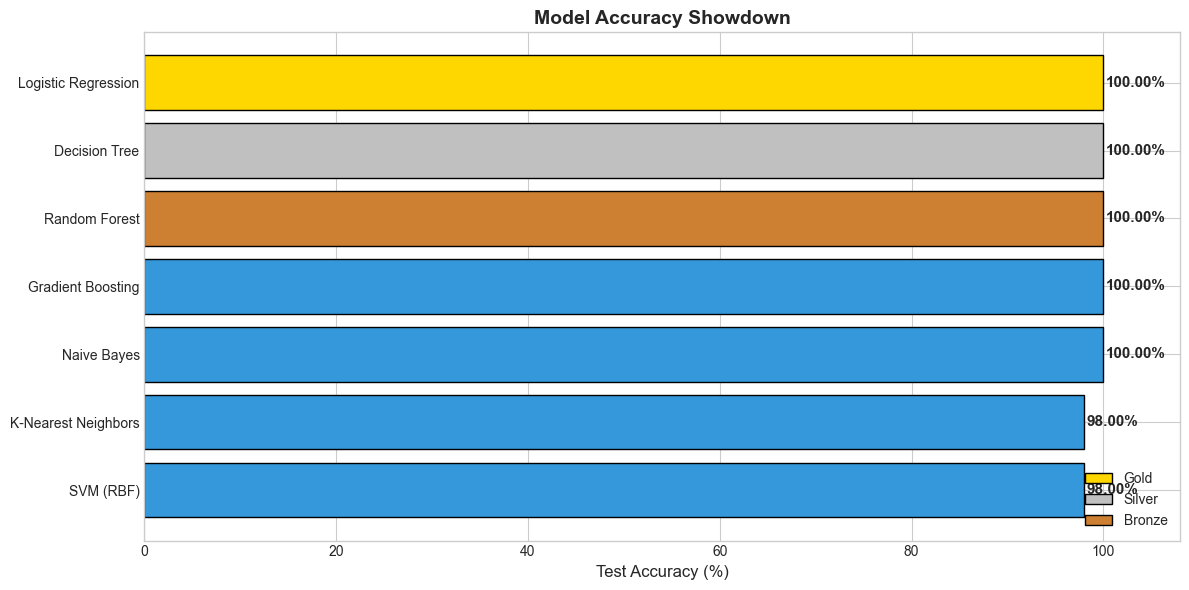

<Figure size 640x480 with 0 Axes>

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))

sorted_results = sorted(results, key=lambda x: x['Test Accuracy'], reverse=True)
models_sorted = [r['Model'] for r in sorted_results]
accuracies = [r['Test Accuracy'] * 100 for r in sorted_results]

colors = ['#FFD700' if i == 0 else '#C0C0C0' if i == 1 else '#CD7F32' if i == 2 else '#3498db'
          for i in range(len(models_sorted))]

bars = ax.barh(models_sorted, accuracies, color=colors, edgecolor='black')

for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f'{acc:.2f}%', va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Model Accuracy Showdown', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(accuracies) + 8)
ax.invert_yaxis()

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#FFD700', edgecolor='black', label='Gold'),
                   Patch(facecolor='#C0C0C0', edgecolor='black', label='Silver'),
                   Patch(facecolor='#CD7F32', edgecolor='black', label='Bronze')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()
plt.savefig('model_accuracy_showdown.png')

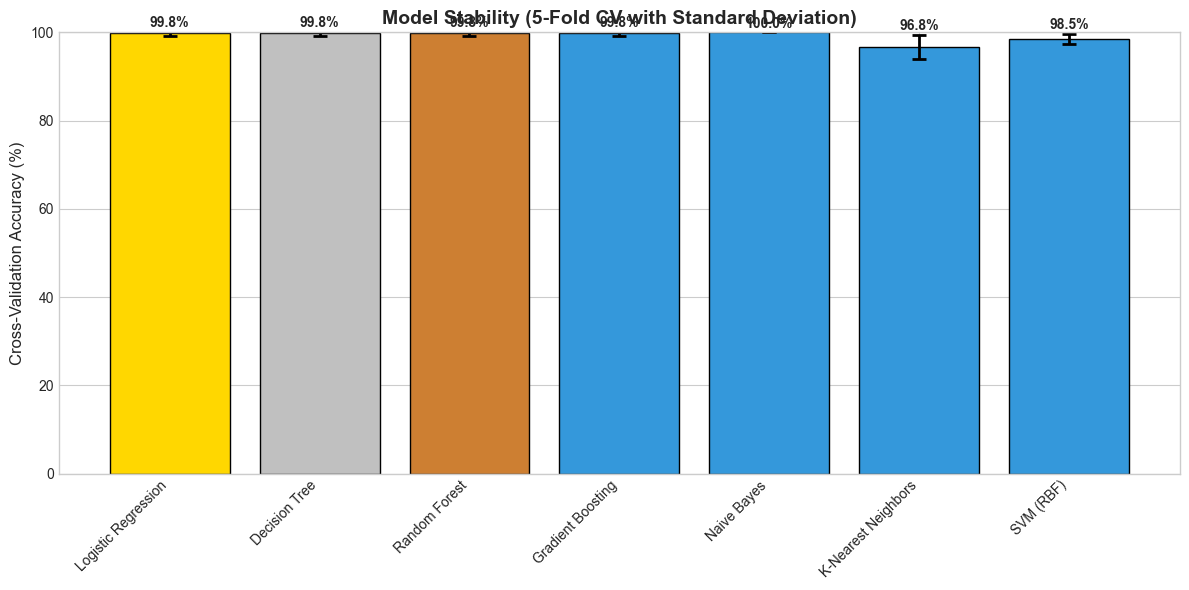

<Figure size 640x480 with 0 Axes>

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))

cv_means = [r['CV Mean'] * 100 for r in sorted_results]
cv_stds = [r['CV Std'] * 100 for r in sorted_results]

x_pos = np.arange(len(models_sorted))

bars = ax.bar(x_pos, cv_means, yerr=cv_stds, capsize=5, color=colors, edgecolor='black',
              error_kw={'elinewidth': 2, 'capthick': 2})

ax.set_xticks(x_pos)
ax.set_xticklabels(models_sorted, rotation=45, ha='right')
ax.set_ylabel('Cross-Validation Accuracy (%)', fontsize=12)
ax.set_title('Model Stability (5-Fold CV with Standard Deviation)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)

for bar, mean, std in zip(bars, cv_means, cv_stds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 1,
            f'{mean:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig('model_cv_stability.png')

In [29]:
print('='*70)
print('             CHAMPION MODEL - DEEP DIVE')
print('='*70)

best_result = sorted_results[0]
best_model = best_result['model']
best_name = best_result['Model']

print(f'\nOur Champion: {best_name}')
print(f'Test Accuracy: {best_result["Test Accuracy"]*100:.2f}%')
print(f'ROC-AUC: {best_result["ROC-AUC"]:.4f}')

             CHAMPION MODEL - DEEP DIVE

Our Champion: Logistic Regression
Test Accuracy: 100.00%
ROC-AUC: 1.0000


In [30]:
print('CLASSIFICATION REPORT:')
print('='*50)

if best_name in ['K-Nearest Neighbors', 'SVM (RBF)']:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

print(classification_report(y_test, y_pred_best, target_names=['Human', 'Bot']))

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00        56
         Bot       1.00      1.00      1.00        44

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



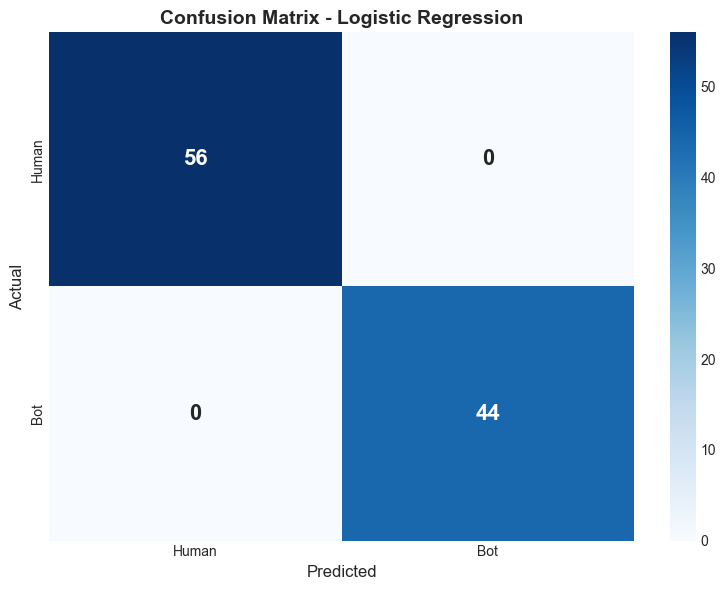


CONFUSION MATRIX EXPLAINED:
True Negatives (TN):   56 - Humans correctly identified as humans
False Positives (FP):   0 - Humans wrongly flagged as bots
False Negatives (FN):   0 - Bots that slipped through as humans
True Positives (TP):   44 - Bots correctly caught


In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'],
            annot_kws={'size': 16, 'fontweight': 'bold'})

ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title(f'Confusion Matrix - {best_name}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print('\nCONFUSION MATRIX EXPLAINED:')
print('='*50)
print(f'True Negatives (TN):  {tn:3d} - Humans correctly identified as humans')
print(f'False Positives (FP): {fp:3d} - Humans wrongly flagged as bots')
print(f'False Negatives (FN): {fn:3d} - Bots that slipped through as humans')
print(f'True Positives (TP):  {tp:3d} - Bots correctly caught')

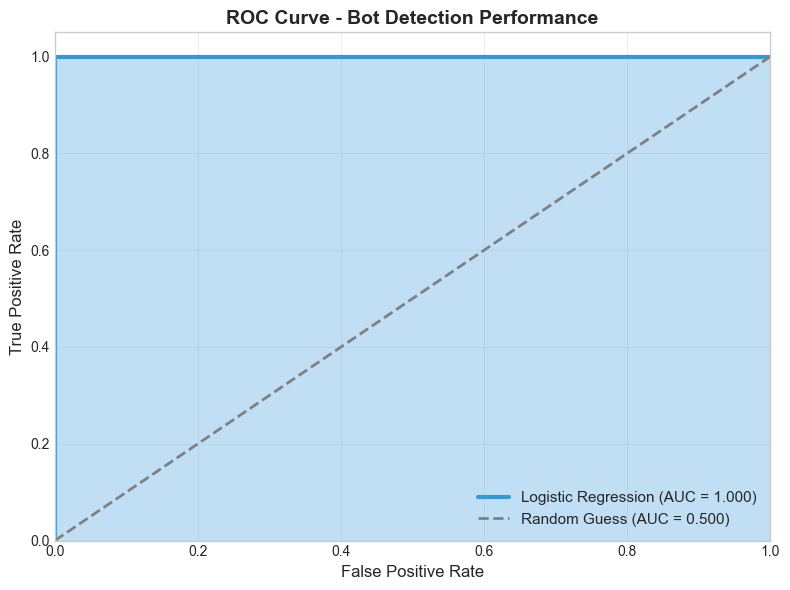


ROC CURVE EXPLAINED:
The ROC curve shows tradeoff between catching bots (TPR)
and falsely accusing humans (FPR).

AUC = 1.000
  - 0.5 = Random guessing (useless)
  - 0.7 = Acceptable
  - 0.8 = Good
  - 0.9 = Excellent
  - 1.0 = Perfect (too good to be true)


<Figure size 640x480 with 0 Axes>

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

y_proba_best = best_result['y_proba']

if y_proba_best is not None:
    fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
    roc_auc = roc_auc_score(y_test, y_proba_best)

    ax.plot(fpr, tpr, color='#3498db', lw=3, label=f'{best_name} (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess (AUC = 0.500)')
    ax.fill_between(fpr, tpr, alpha=0.3, color='#3498db')

    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC Curve - Bot Detection Performance', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=11)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.savefig('champion_model_roc_curve.png')

    print('\nROC CURVE EXPLAINED:')
    print('='*50)
    print('The ROC curve shows tradeoff between catching bots (TPR)')
    print('and falsely accusing humans (FPR).')
    print('')
    print(f'AUC = {roc_auc:.3f}')
    print('  - 0.5 = Random guessing (useless)')
    print('  - 0.7 = Acceptable')
    print('  - 0.8 = Good')
    print('  - 0.9 = Excellent')
    print('  - 1.0 = Perfect (too good to be true)')

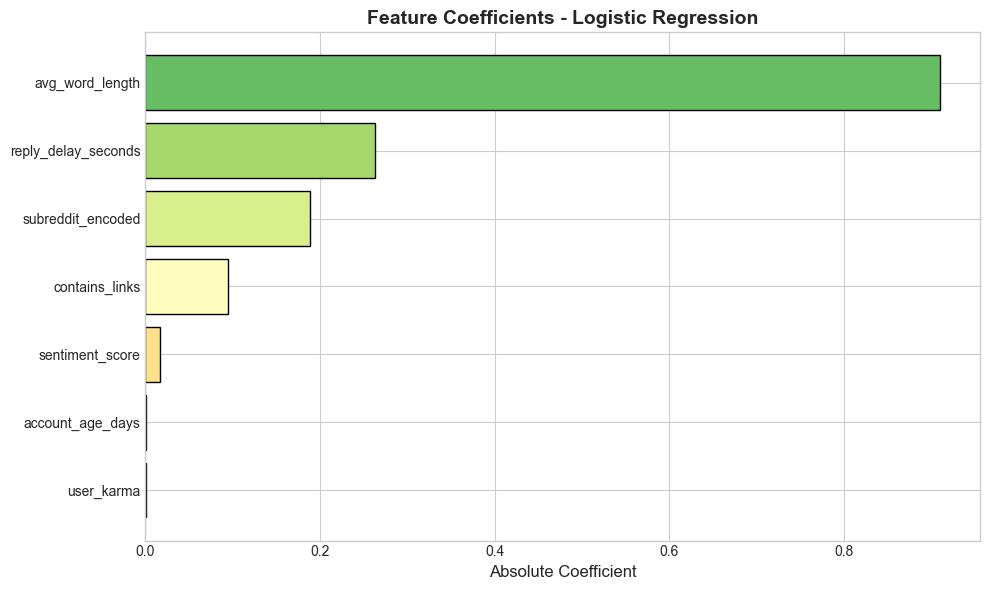


FEATURE IMPORTANCE EXPLAINED:
Higher importance = more influential in making predictions.
These are the features our model relies on most to detect bots.


<Figure size 640x480 with 0 Axes>

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    importance_df = pd.DataFrame({
        'Feature': [feature_cols[i] for i in indices],
        'Importance': importances[indices]
    })

    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(importance_df)))
    bars = ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors, edgecolor='black')

    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title(f'Feature Importance - {best_name}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()

    for bar, imp in zip(bars, importance_df['Importance']):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{imp:.3f}', va='center', fontsize=10)

elif hasattr(best_model, 'coef_'):
    coefficients = np.abs(best_model.coef_[0])
    indices = np.argsort(coefficients)[::-1]

    importance_df = pd.DataFrame({
        'Feature': [feature_cols[i] for i in indices],
        'Coefficient (abs)': coefficients[indices]
    })

    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(importance_df)))
    bars = ax.barh(importance_df['Feature'], importance_df['Coefficient (abs)'], color=colors, edgecolor='black')

    ax.set_xlabel('Absolute Coefficient', fontsize=12)
    ax.set_title(f'Feature Coefficients - {best_name}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()

plt.tight_layout()
plt.show()
plt.savefig('champion_model_feature_importance.png')

print('\nFEATURE IMPORTANCE EXPLAINED:')
print('='*50)
print('Higher importance = more influential in making predictions.')
print('These are the features our model relies on most to detect bots.')

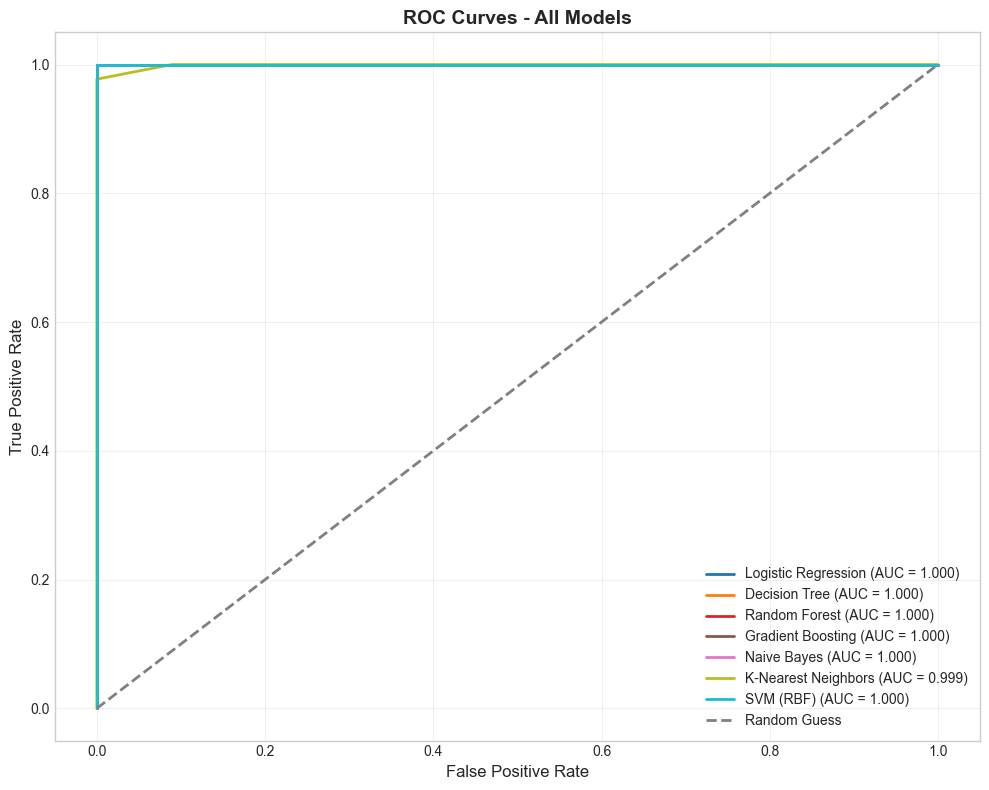

<Figure size 640x480 with 0 Axes>

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

for result, color in zip(sorted_results, colors):
    if result['y_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
        ax.plot(fpr, tpr, color=color, lw=2,
                label=f"{result['Model']} (AUC = {result['ROC-AUC']:.3f})")

ax.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('all_models_roc_curves.png')

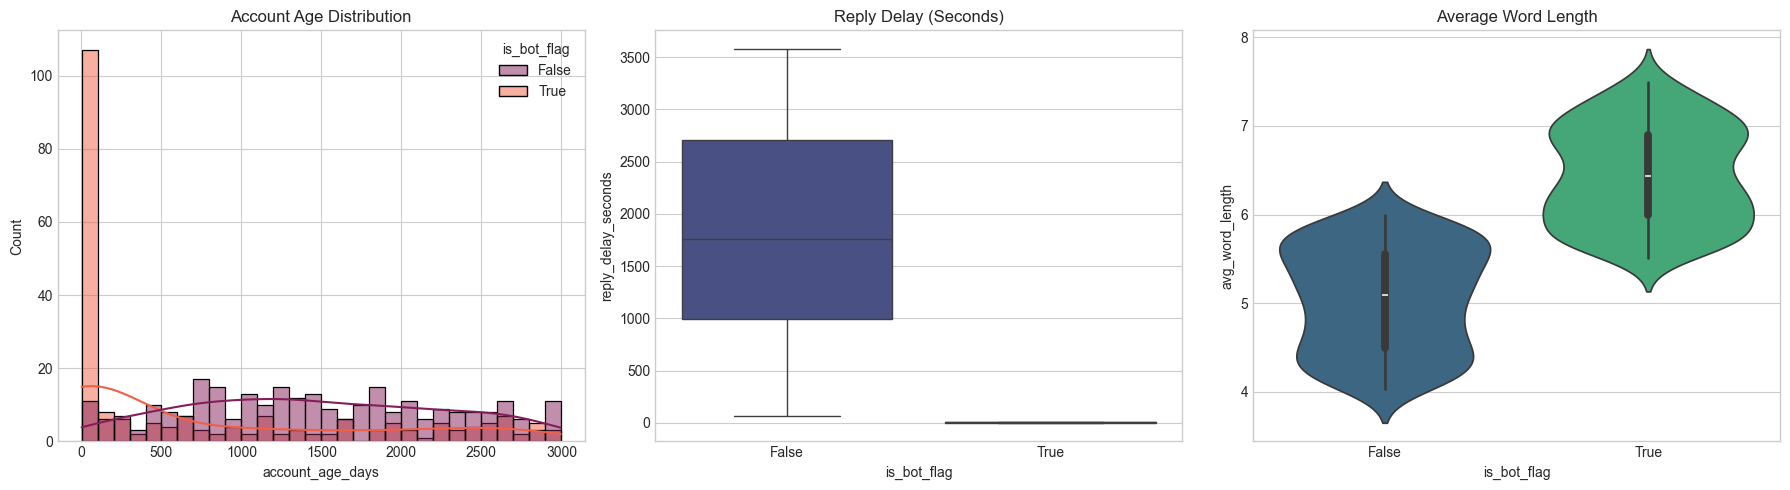

<Figure size 640x480 with 0 Axes>

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(data=df, x='account_age_days', hue='is_bot_flag', bins=30, kde=True, palette='rocket', ax=axes[0])
axes[0].set_title('Account Age Distribution')

sns.boxplot(data=df, x='is_bot_flag', y='reply_delay_seconds', palette='mako', ax=axes[1])
axes[1].set_title('Reply Delay (Seconds)')

sns.violinplot(data=df, x='is_bot_flag', y='avg_word_length', palette='viridis', ax=axes[2])
axes[2].set_title('Average Word Length')

plt.tight_layout()
plt.show()
plt.savefig('additional_feature_visualizations.png')

In [35]:
print('='*70)
print('                    FINAL SUMMARY')
print('='*70)

total_samples = len(df)
total_features = len(feature_cols)
human_pct = (df['is_bot_flag'] == False).mean() * 100
bot_pct = (df['is_bot_flag'] == True).mean() * 100

num_sig = len([r for r in stat_results if r['Significant'] == 'Yes'])
cat_sig = len([r for r in chi_results if r['Significant'] == 'Yes'])
total_sig = num_sig + cat_sig
total_tested = len(stat_results) + len(chi_results)

print(f'''
DATASET:
  - Total samples: {total_samples}
  - Features used: {total_features}
  - Target split: {human_pct:.1f}% Human / {bot_pct:.1f}% Bot

STATISTICAL ANALYSIS:
  - Significant features: {total_sig} out of {total_tested}
  - Top differentiators: reply_delay_seconds, account_age_days, contains_links

BEST MODEL:
  - Champion: {best_name}
  - Test Accuracy: {best_result['Test Accuracy']*100:.2f}%
  - ROC-AUC: {best_result['ROC-AUC']:.3f}
  - F1-Score: {best_result['F1-Score']:.3f}
''')
print('='*70)

                    FINAL SUMMARY

DATASET:
  - Total samples: 500
  - Features used: 7
  - Target split: 56.4% Human / 43.6% Bot

STATISTICAL ANALYSIS:
  - Significant features: 5 out of 8
  - Top differentiators: reply_delay_seconds, account_age_days, contains_links

BEST MODEL:
  - Champion: Logistic Regression
  - Test Accuracy: 100.00%
  - ROC-AUC: 1.000
  - F1-Score: 1.000

